In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [702]:
sADF=pd.read_csv(r"Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [1311]:
#sADF.head()
#print(sADF.shape,sBDF.shape)
#print(sADF.columns,sBDF.columns)
#sADF["Timestamp"][0]

In [1312]:
pd.to_datetime(sADF["Timestamp"]);
pd.to_datetime(sBDF["Timestamp"]);

In [1313]:
def IdentifyEvents_3(df,dry_hours_skip,moving_hours):
    #  This method use moving STD (std_mov) (last (moving_hours) hours) for start and end of an event
    # For the start of an event use: std_mov > *8 percent of range of std_mov 
    # To detect the end of an event use: std_mov < 3 percentage of range of std_mov
    skip=int(dry_hours_skip*(60/5))    # (dry_hours_skip) hours of no significant change in water level means start of another event
    #wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    
    ###### this part calculates the moving STD
    std_mov=moving_std(df,moving_hours)      # calculates STD of last (moving_hours) hours
    rng3p=np.max(std_mov)*(3/100)            # 3 percent of the range of moving STD
    rng8p=np.max(std_mov)*(7.5/100)          # 7.5 percent of the range of moving STD
    ########################################
    
    nre=True     #indicator if the current time falls under "No Rain Event" or not
    # rpc=0
    #dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    #duration=[]
    i=1
    while i<df.shape[0]-1:
        if std_mov[i]>=rng8p:
            if nre==True:
                # This is a new rainfall event
                start_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                start_index.append(df.index.to_list()[0]+i)
                nre=False
                i+=1
            while std_mov[i]>rng3p:
                i+=1
            if np.max(std_mov[i+1:i+skip+1])<rng8p:
                # dry period starts from index i+1
                end_time.append(df["Timestamp"][df.index.to_list()[0]+i])
                end_index.append(df.index.to_list()[0]+i)
                nre=True
                i=i+skip
        i+=1

    return start_time,end_time,start_index,end_index,np.subtract(end_index,start_index),wl_mm

In [1282]:
# Calculate moving STD of last *few hours
def moving_std(df,period_in_hour):      
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_std=[0]
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_std.append(np.std(wl_mm[:i+1]))
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mov_std.append(np.std(wl_mm[i-periods:i+1]))
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mov_std
#Calculate moving MEAN of last *few hours
def moving_mean(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mean_mov=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mean_mov.append(np.mean(wl_mm[:i+1]))
        else:
            mean_mov.append(np.mean(wl_mm[i-periods:i+1]))
    return mean_mov

# Calculate moving MAX of last *few hours
def moving_max(df,period_in_hour):
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    mov_max=[wl_mm[0]]
    for i in range(np.size(wl_mm)):
        periods=int(period_in_hour*(60/5))    
        if i<periods:
            mov_max.append(np.max(wl_mm[:i+1]))
        else:
            mov_max.append(np.max(wl_mm[i-periods:i+1]))
    return mov_max

14.894451850536207 37.23612962634052


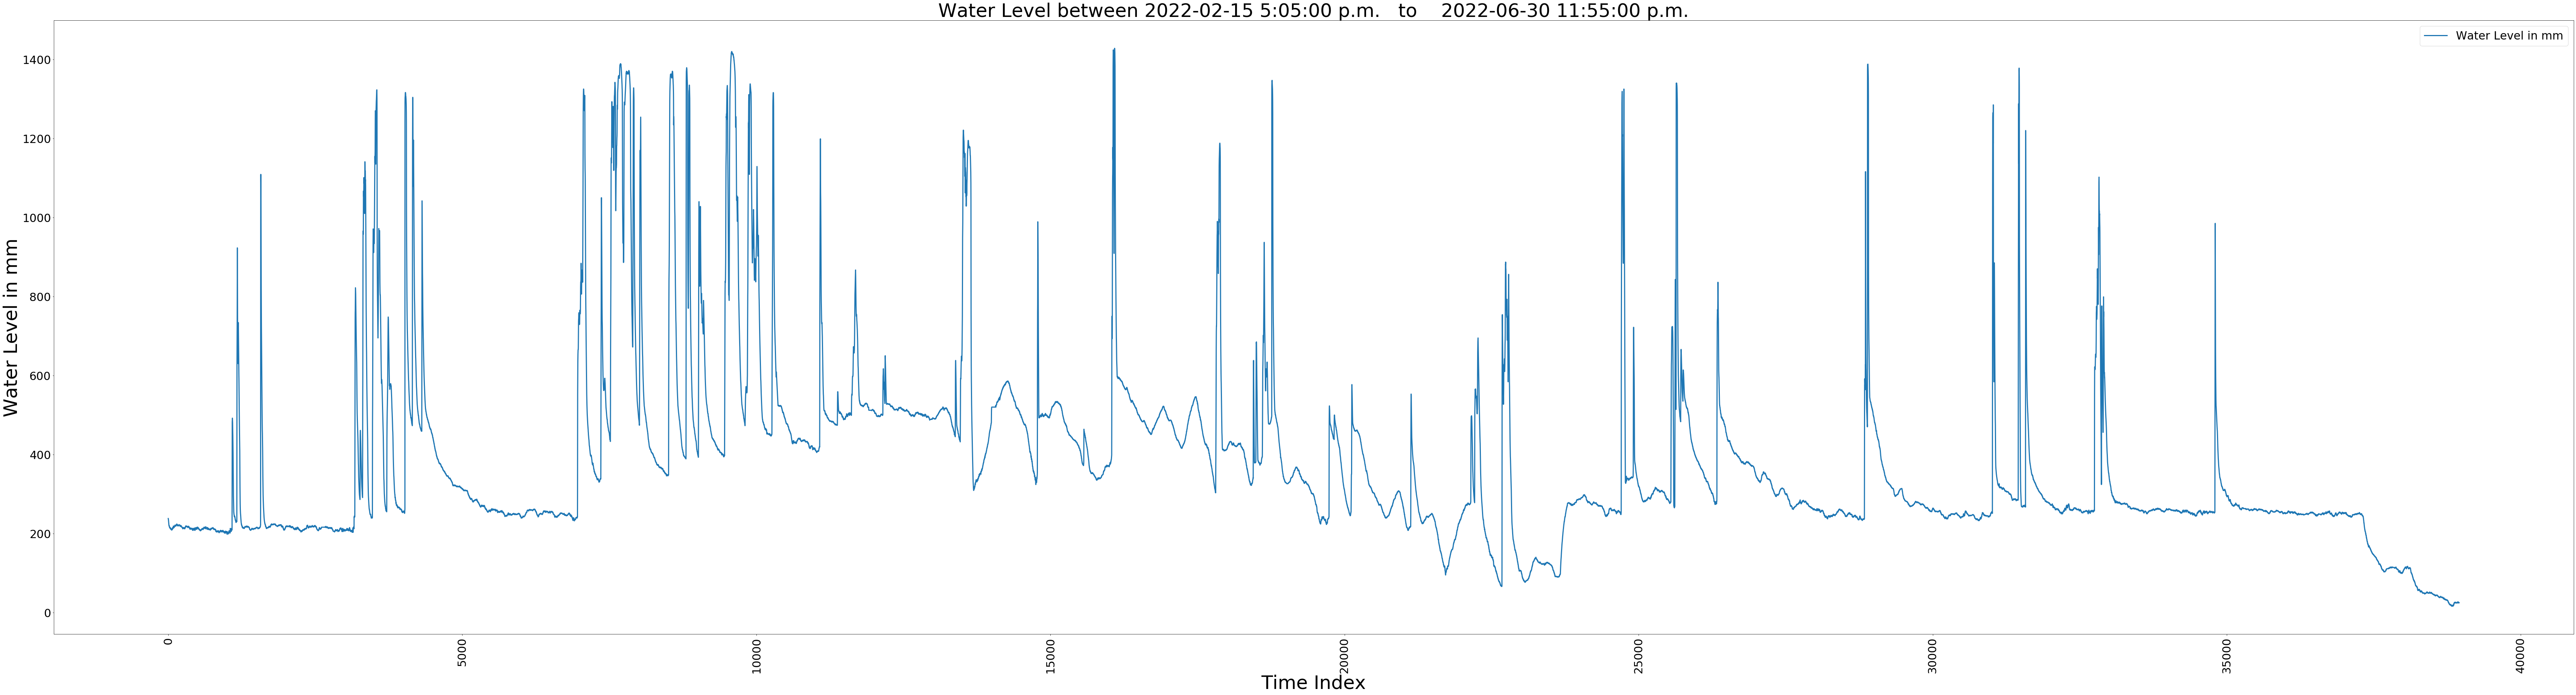

In [1314]:
std_movA=moving_std(sADF,6)
rng3pA=np.max(std_movA)*(3/100)
rng8pA=np.max(std_movA)*(7.5/100)
print(rng3pA,rng8pA)
#np.mean(std_movA)
plt.figure(figsize=(120, 30))
plt.plot(wl_mmA,linewidth=3,label="Water Level in mm")
#plt.plot(std_movA,linewidth=3,color="green")
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=30)
plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=50)
plt.show()

In [1315]:
# This part calculate all rainfall events
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_levelA=IdentifyEvents_3(sADF,6,6)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:50:00 a.m.,2022-02-20 5:05:00 a.m.,1089,1296,207
1,2022-02-21 4:05:00 a.m.,2022-02-21 2:05:00 p.m.,1572,1692,120
2,2022-02-26 5:45:00 p.m.,2022-03-01 7:25:00 a.m.,3176,3916,740
3,2022-03-01 4:35:00 p.m.,2022-03-03 3:10:00 a.m.,4026,4441,415
4,2022-03-11 9:15:00 p.m.,2022-03-12 7:55:00 p.m.,6962,7234,272
5,2022-03-13 7:20:00 a.m.,2022-03-16 7:25:00 a.m.,7359,8224,865
6,2022-03-17 7:20:00 a.m.,2022-03-19 10:30:00 p.m.,8511,9269,758
7,2022-03-20 2:50:00 p.m.,2022-03-23 1:00:00 a.m.,9465,10163,698
8,2022-03-23 9:55:00 a.m.,2022-03-23 10:40:00 p.m.,10270,10423,153
9,2022-03-26 5:25:00 a.m.,2022-03-26 4:15:00 p.m.,11080,11210,130


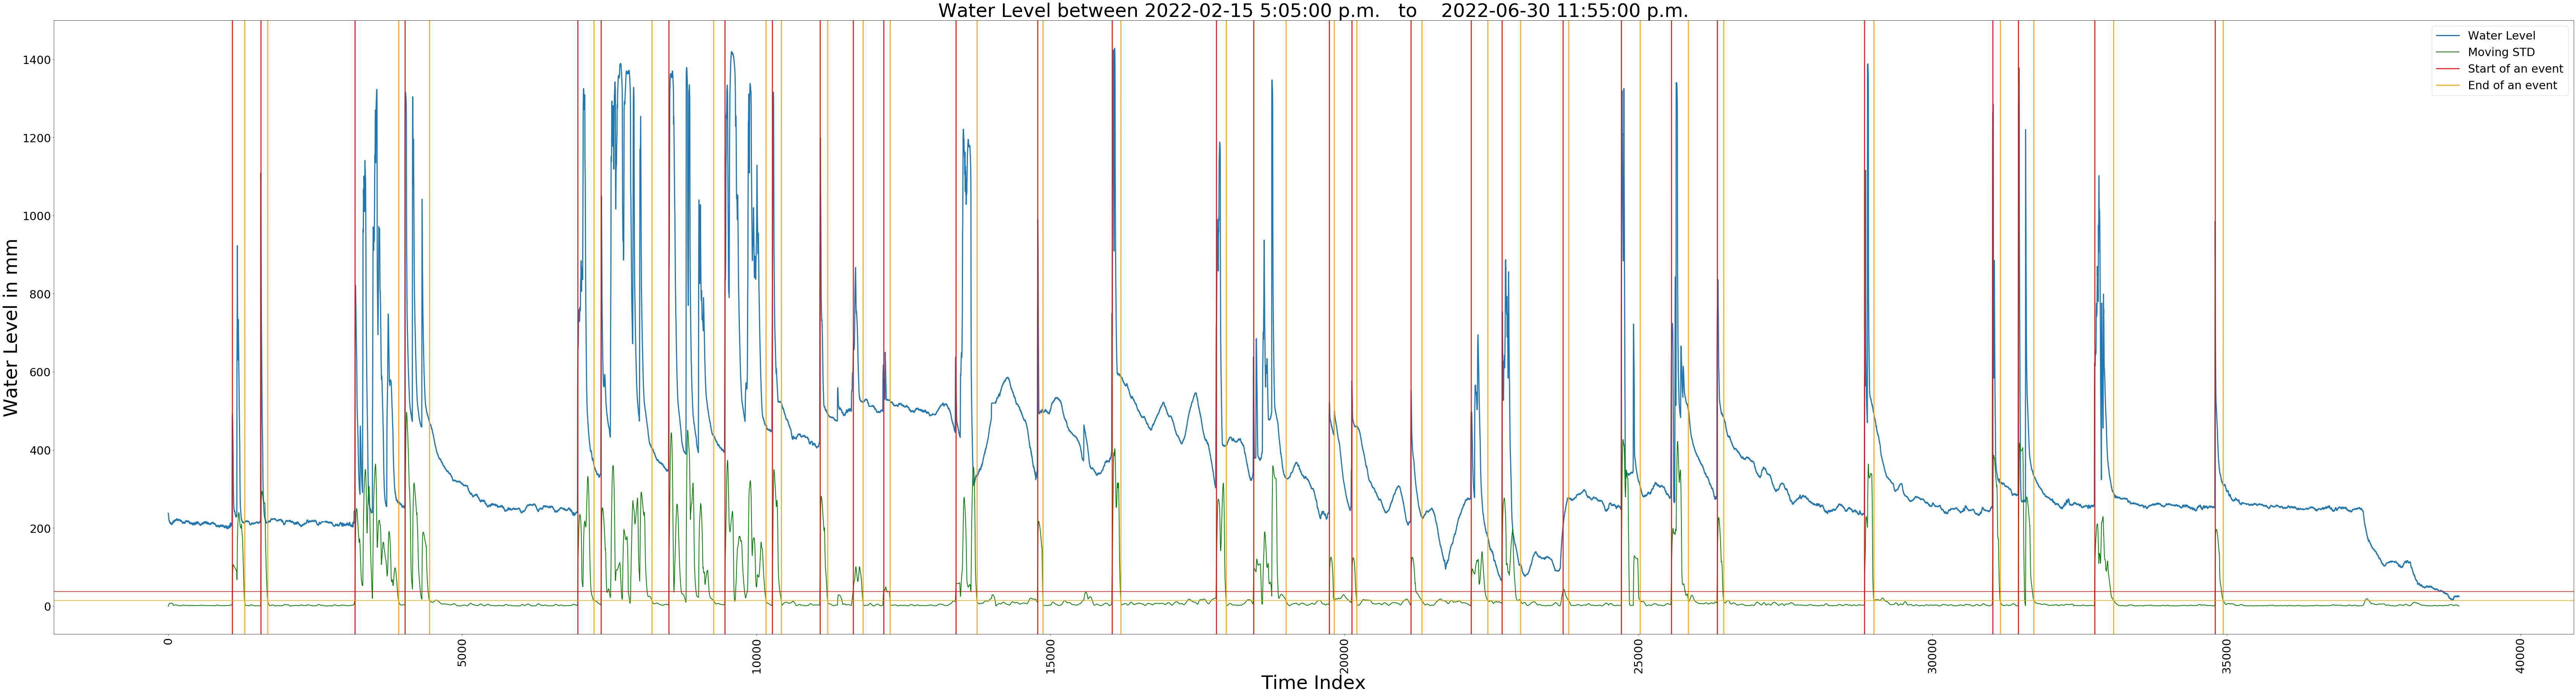

In [1316]:
# This draw all data set with events being identified
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelA,label='Water Level',linewidth=3)
#plt.plot(mean_mov)
mstd,=plt.plot(std_movA,label="Moving STD",linewidth=2,color="green")
for i in start_indexA:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexA:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rng3pA, color='orange', linestyle='-')
plt.axhline(y=rng8pA, color='red', linestyle='-')
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.title("Water Level between "+sADF["Timestamp"][0]+"   to    "+sADF["Timestamp"][sADF.shape[0]-1],fontsize=50)
plt.show()

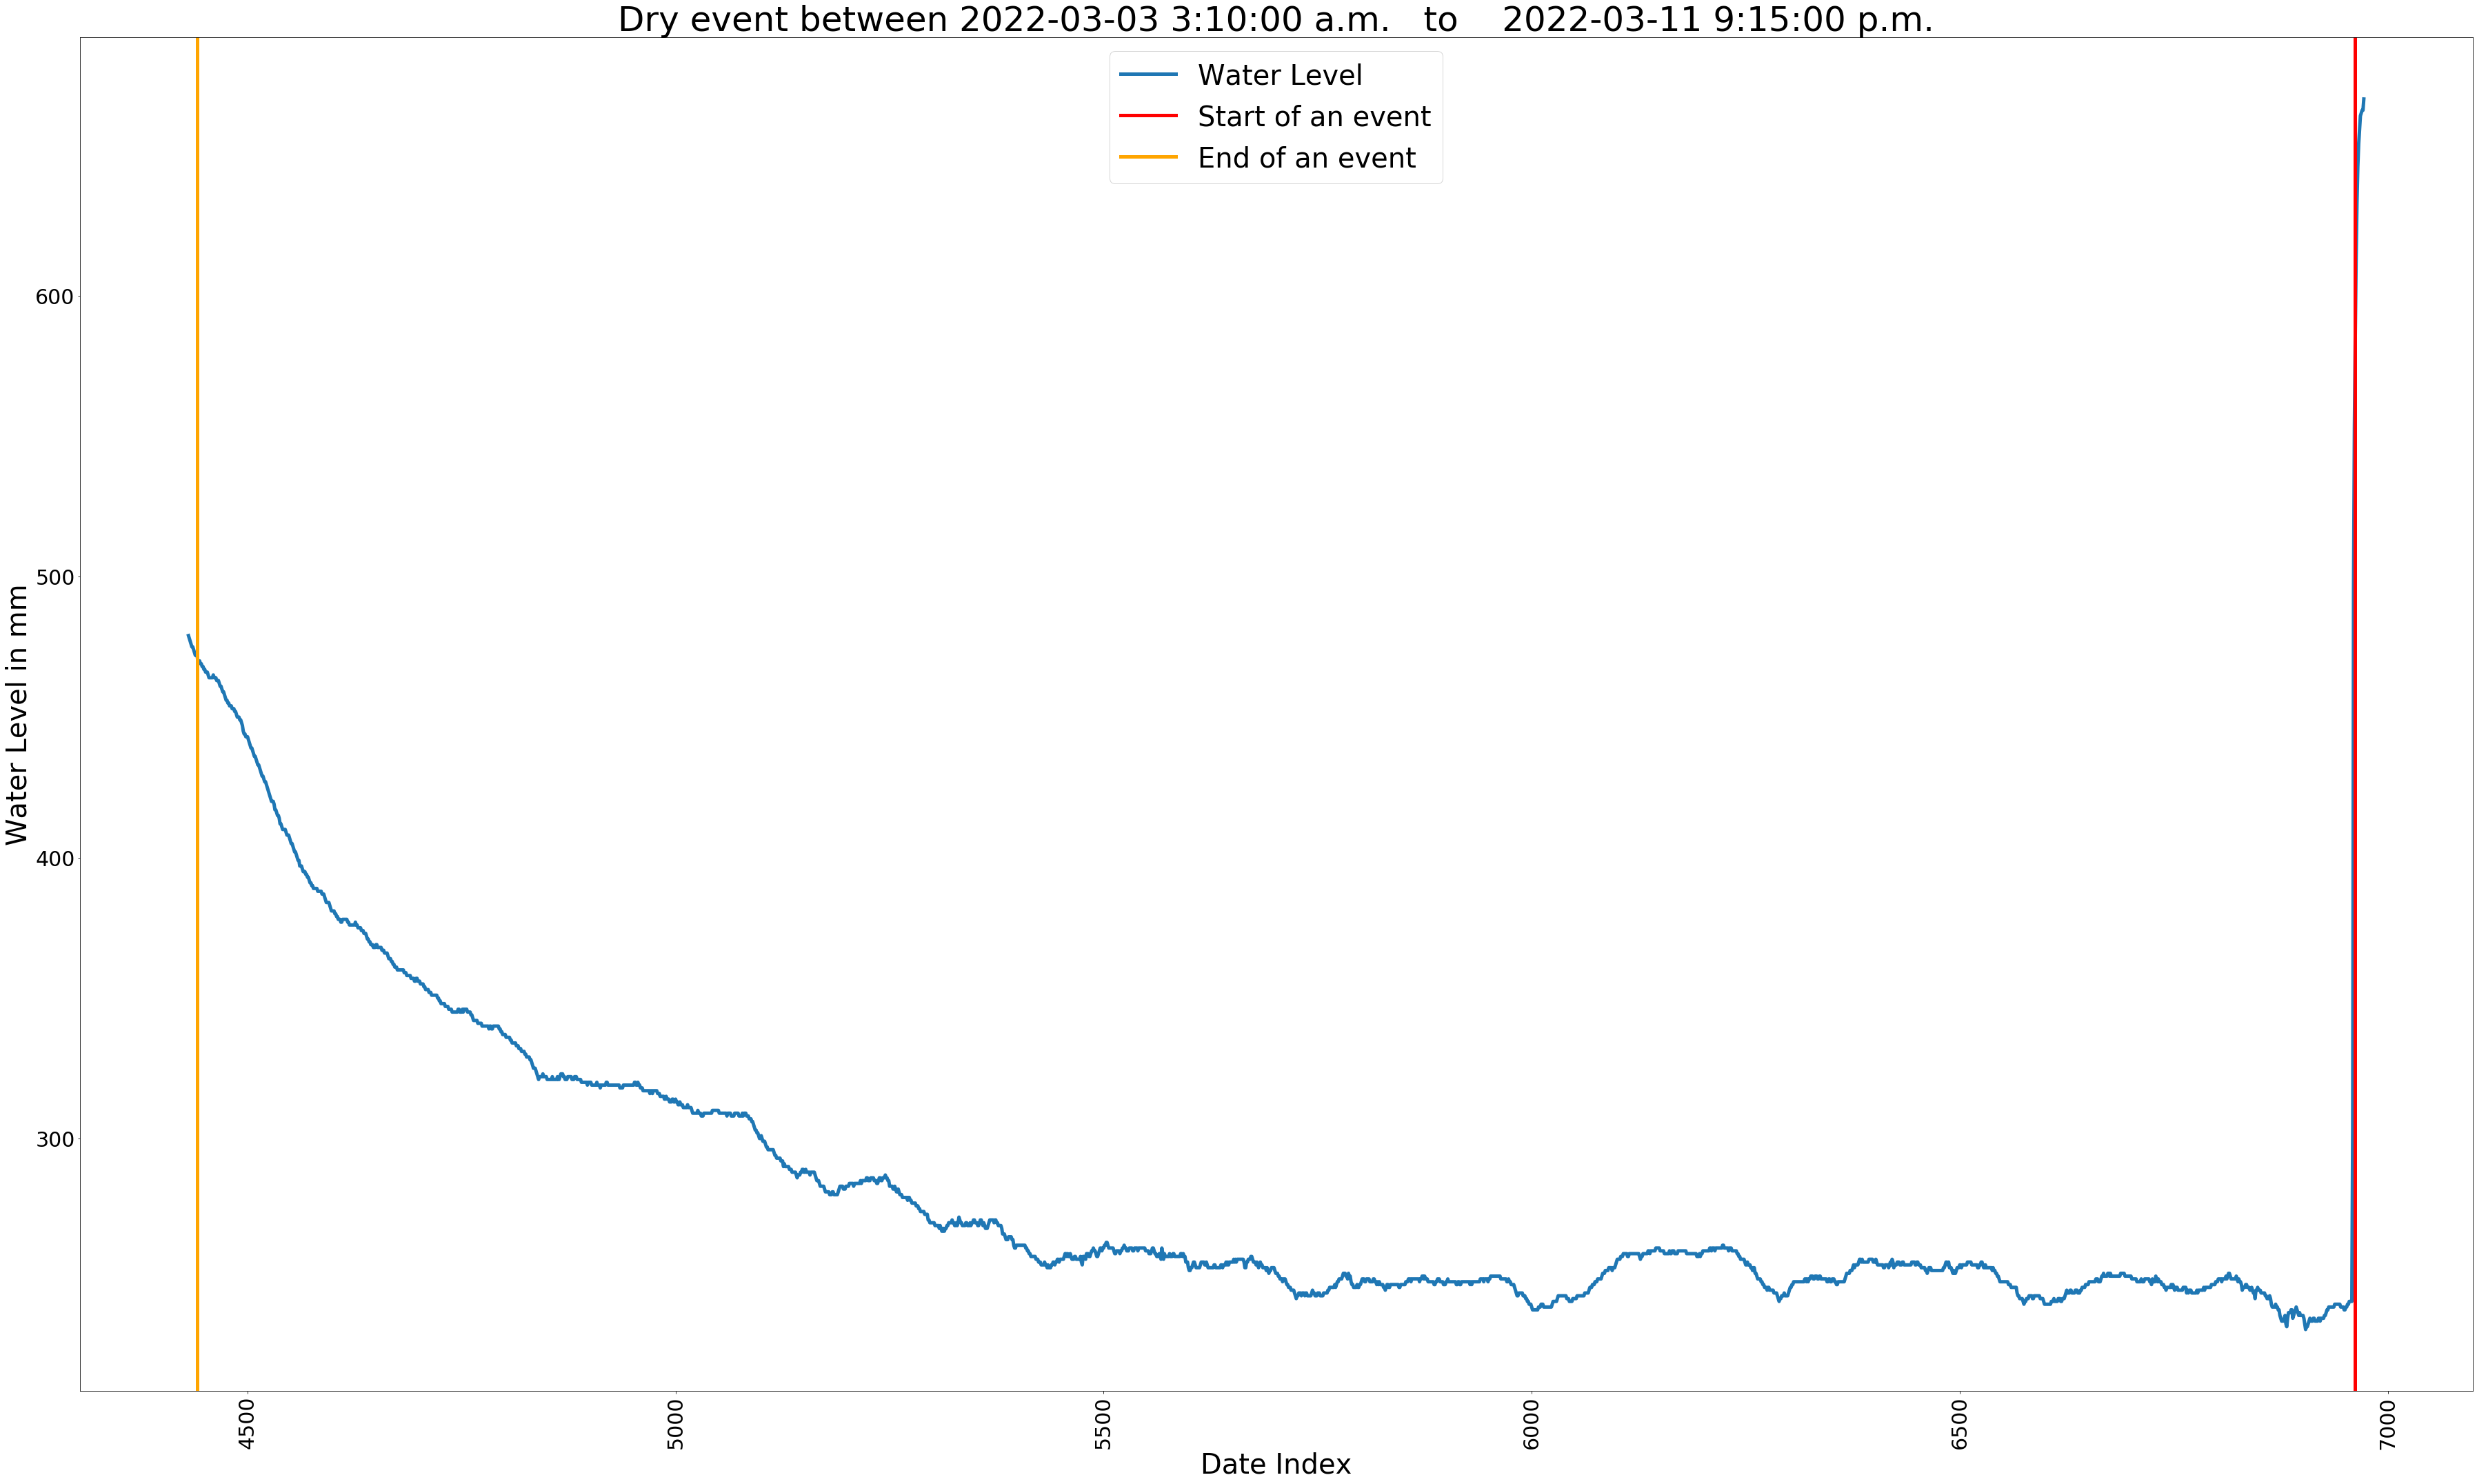

In [1318]:
# Let's look at a particular No !Rainfall event
buffer=10
index=4
X=range(end_indexA[index-1]-buffer,start_indexA[index]+buffer+1)
Y=water_levelA[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title("Dry event between "+end_timeA[index-1]+"   to    "+start_timeA[index],fontsize=50)
plt.tight_layout()
plt.show()

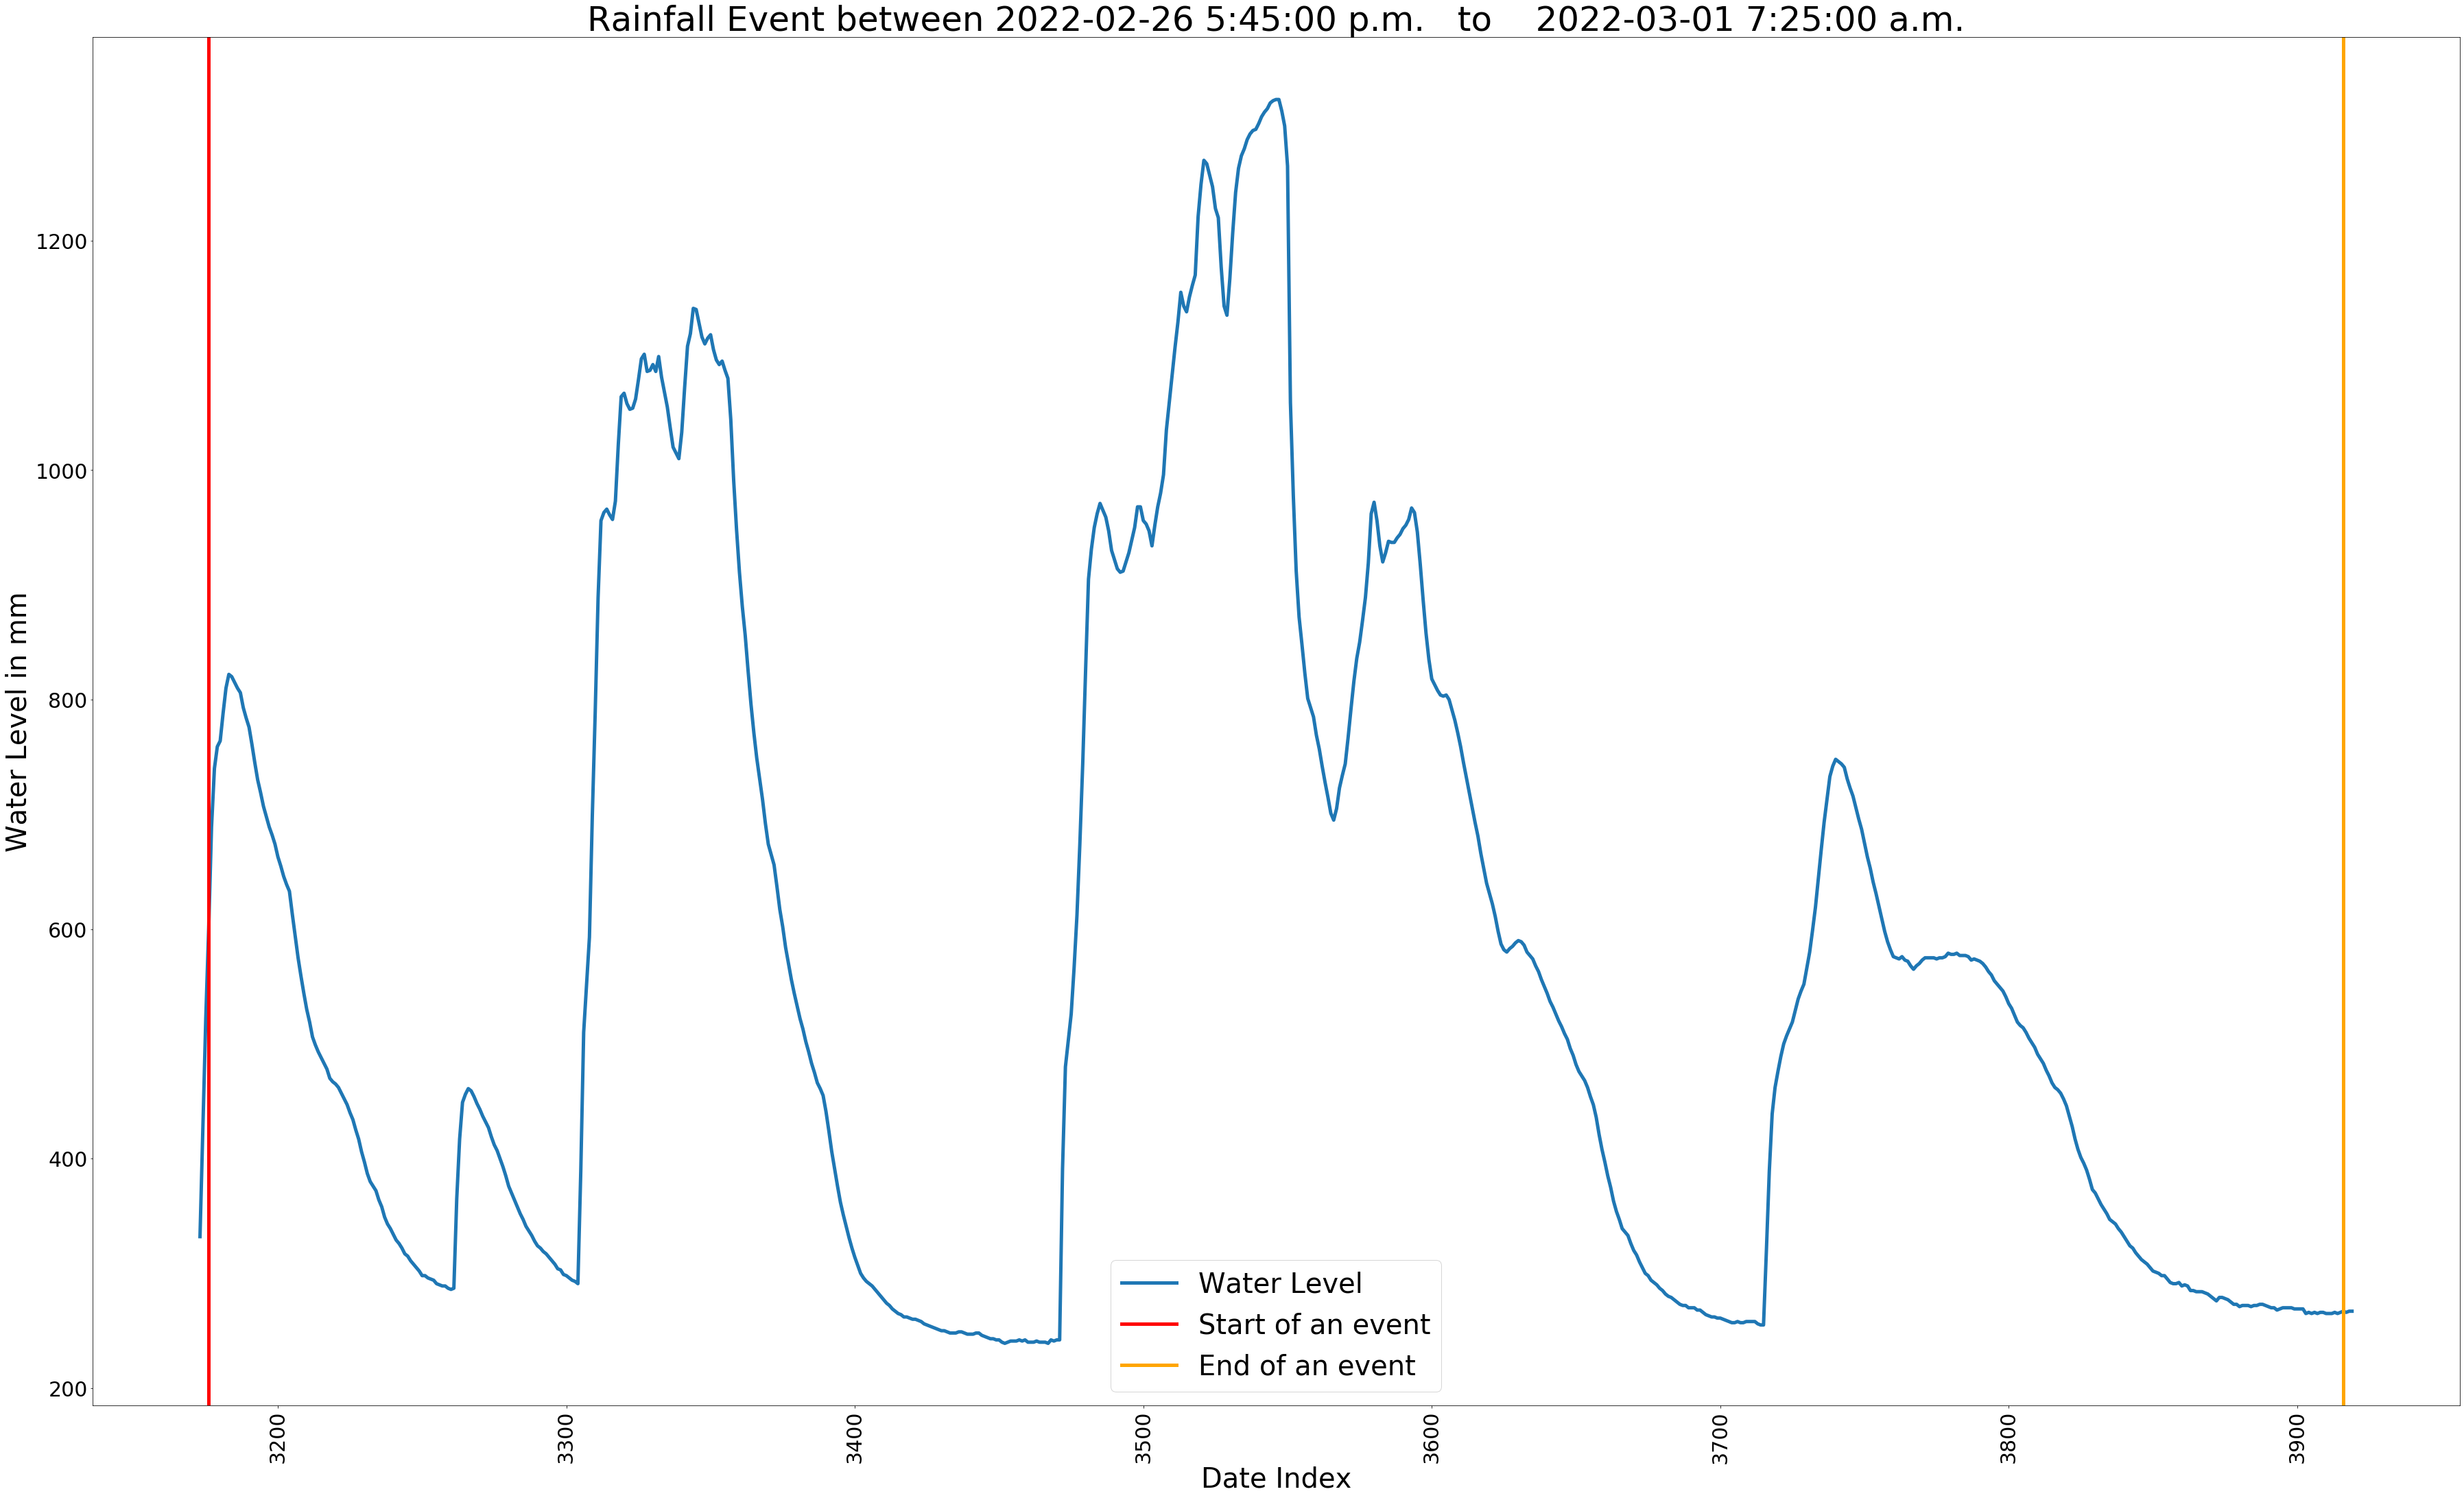

In [1320]:
# Let's see a particular !Rainfall event
buffer=3
index=2
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexA[index]-buffer,end_indexA[index]+buffer+1)
Y=water_levelA[start_indexA[index]-buffer:end_indexA[index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexA[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexA[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title("Rainfall Event between "+start_timeA[index]+"   to    "+end_timeA[index],fontsize=50)
plt.show()

747


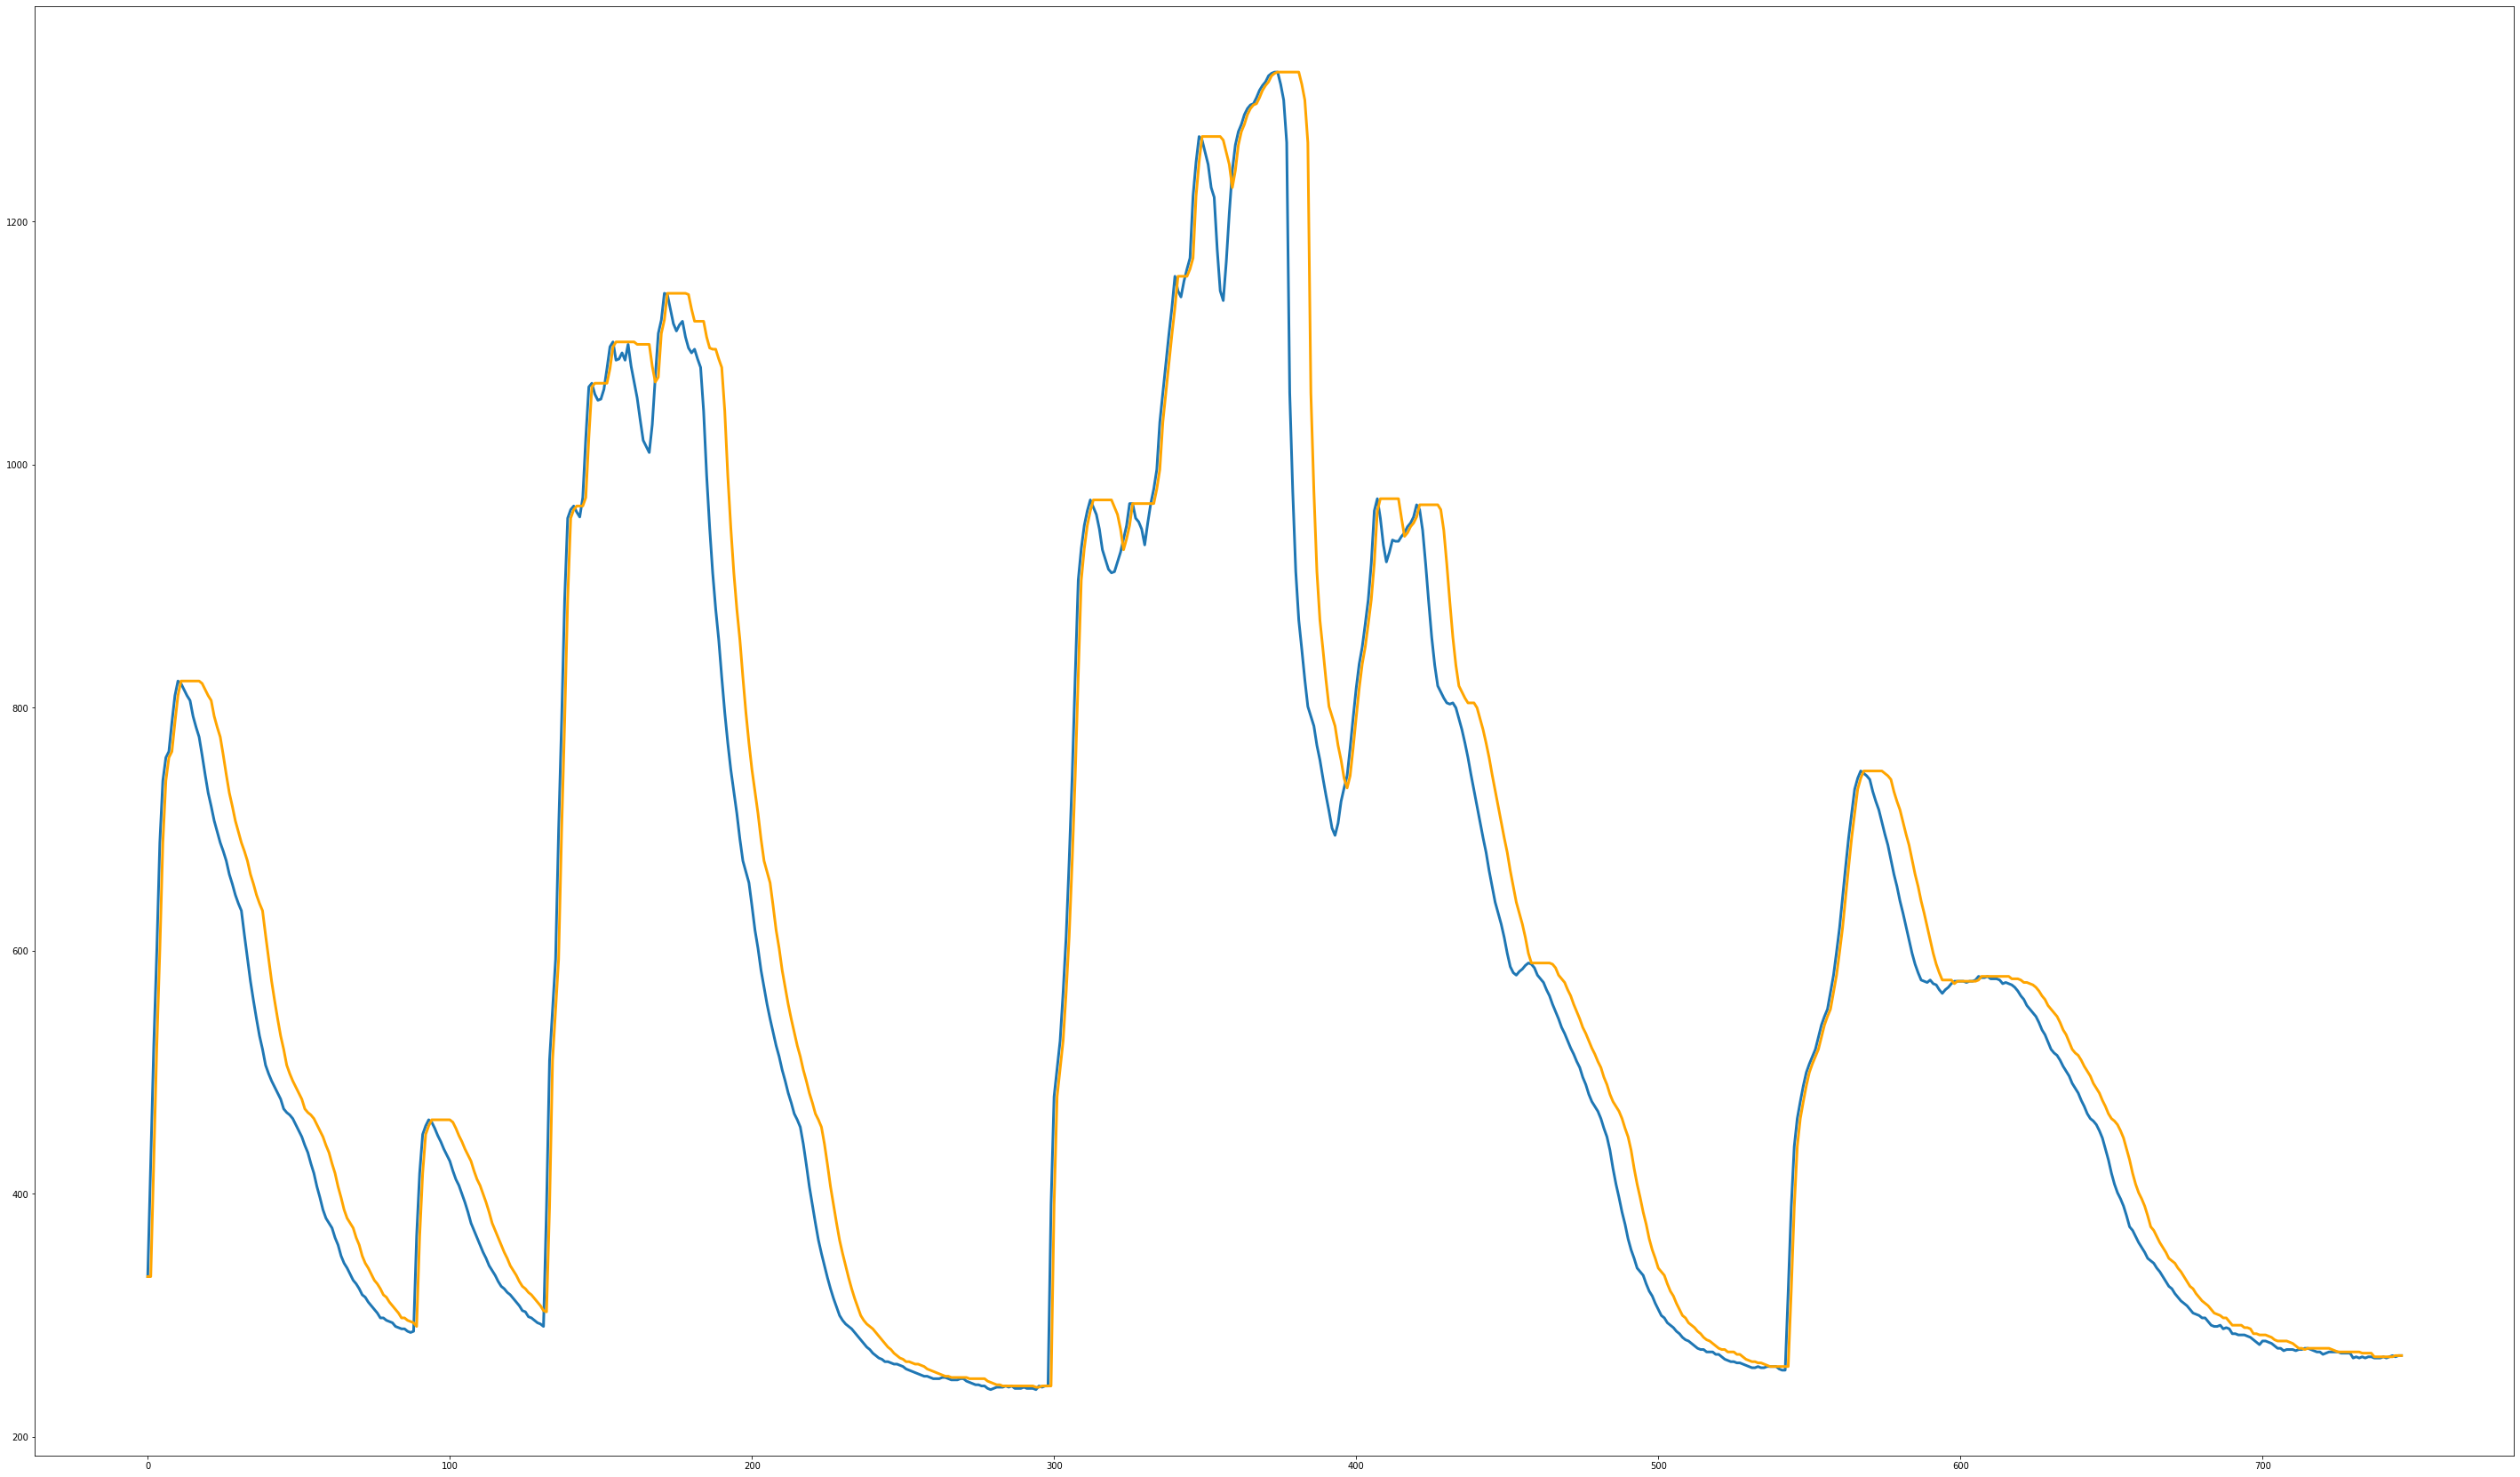

In [1321]:
# This part draws a particular event with moving MAX
buffer=3
index=2
max_mov=moving_max(sADF[start_indexA[index]-buffer:end_indexA[index]+buffer],0.5)
std_mov=moving_std(sADF[start_indexA[index]-buffer:end_indexA[index]+buffer],0.5)
wl=water_levelA[start_indexA[index]-buffer:end_indexA[index]+buffer+1]
print(np.size(wl))
plt.figure(figsize=(50, 30))
plt.plot(wl,linewidth=3)
plt.plot(max_mov,linewidth=3,color="orange")

In [1322]:
# finding peak and bottom (wellflood duration)
np.size(wl)
np.size(std_mov)
start=[]
end=[]
i=1
while i <np.size(wl)-1:
    if max_mov[i]-wl[i]>2:
        start.append(i-1)
        while max_mov[i]-wl[i]>0:
            i+=1
            if i>=np.size(wl):
                break
        end.append(i-1)
    i+=1
np.size(start)

19

In [1323]:
# Discards peaks that's have very small amount of drawdown
i=0
while i<np.size(start)-1:
    if abs(wl[start[i]]-wl[end[i]])<150:
        if wl[start[i]]<wl[start[i+1]]:
            start.pop(i)
            end.pop(i)
        else:
            start.pop(i+1)
            end.pop(i)
        continue
    else:
        i+=1
print(start)
i=0
while i<np.size(start)-1:  
    if abs(wl[end[i]]-wl[start[i+1]])<150:
        end.pop(i)
        start.pop(i+1)
        continue
    else:
        i+=1
print(start)
# Discard peaks which are very close to each other
i=0
while i<np.size(start)-1:
    if (start[i+1]-start[i])<25:
        if wl[start[i+1]]>wl[start[i]]:
            start.pop(i)
            end.pop(i)
        else:
            start.pop(i+1)
            end.pop(i)
        continue
    else:
        i+=1   
print(start)

[10, 93, 172, 374, 407, 568, 612, 717]
[10, 93, 172, 374, 407, 568]
[10, 93, 172, 374, 407, 568]


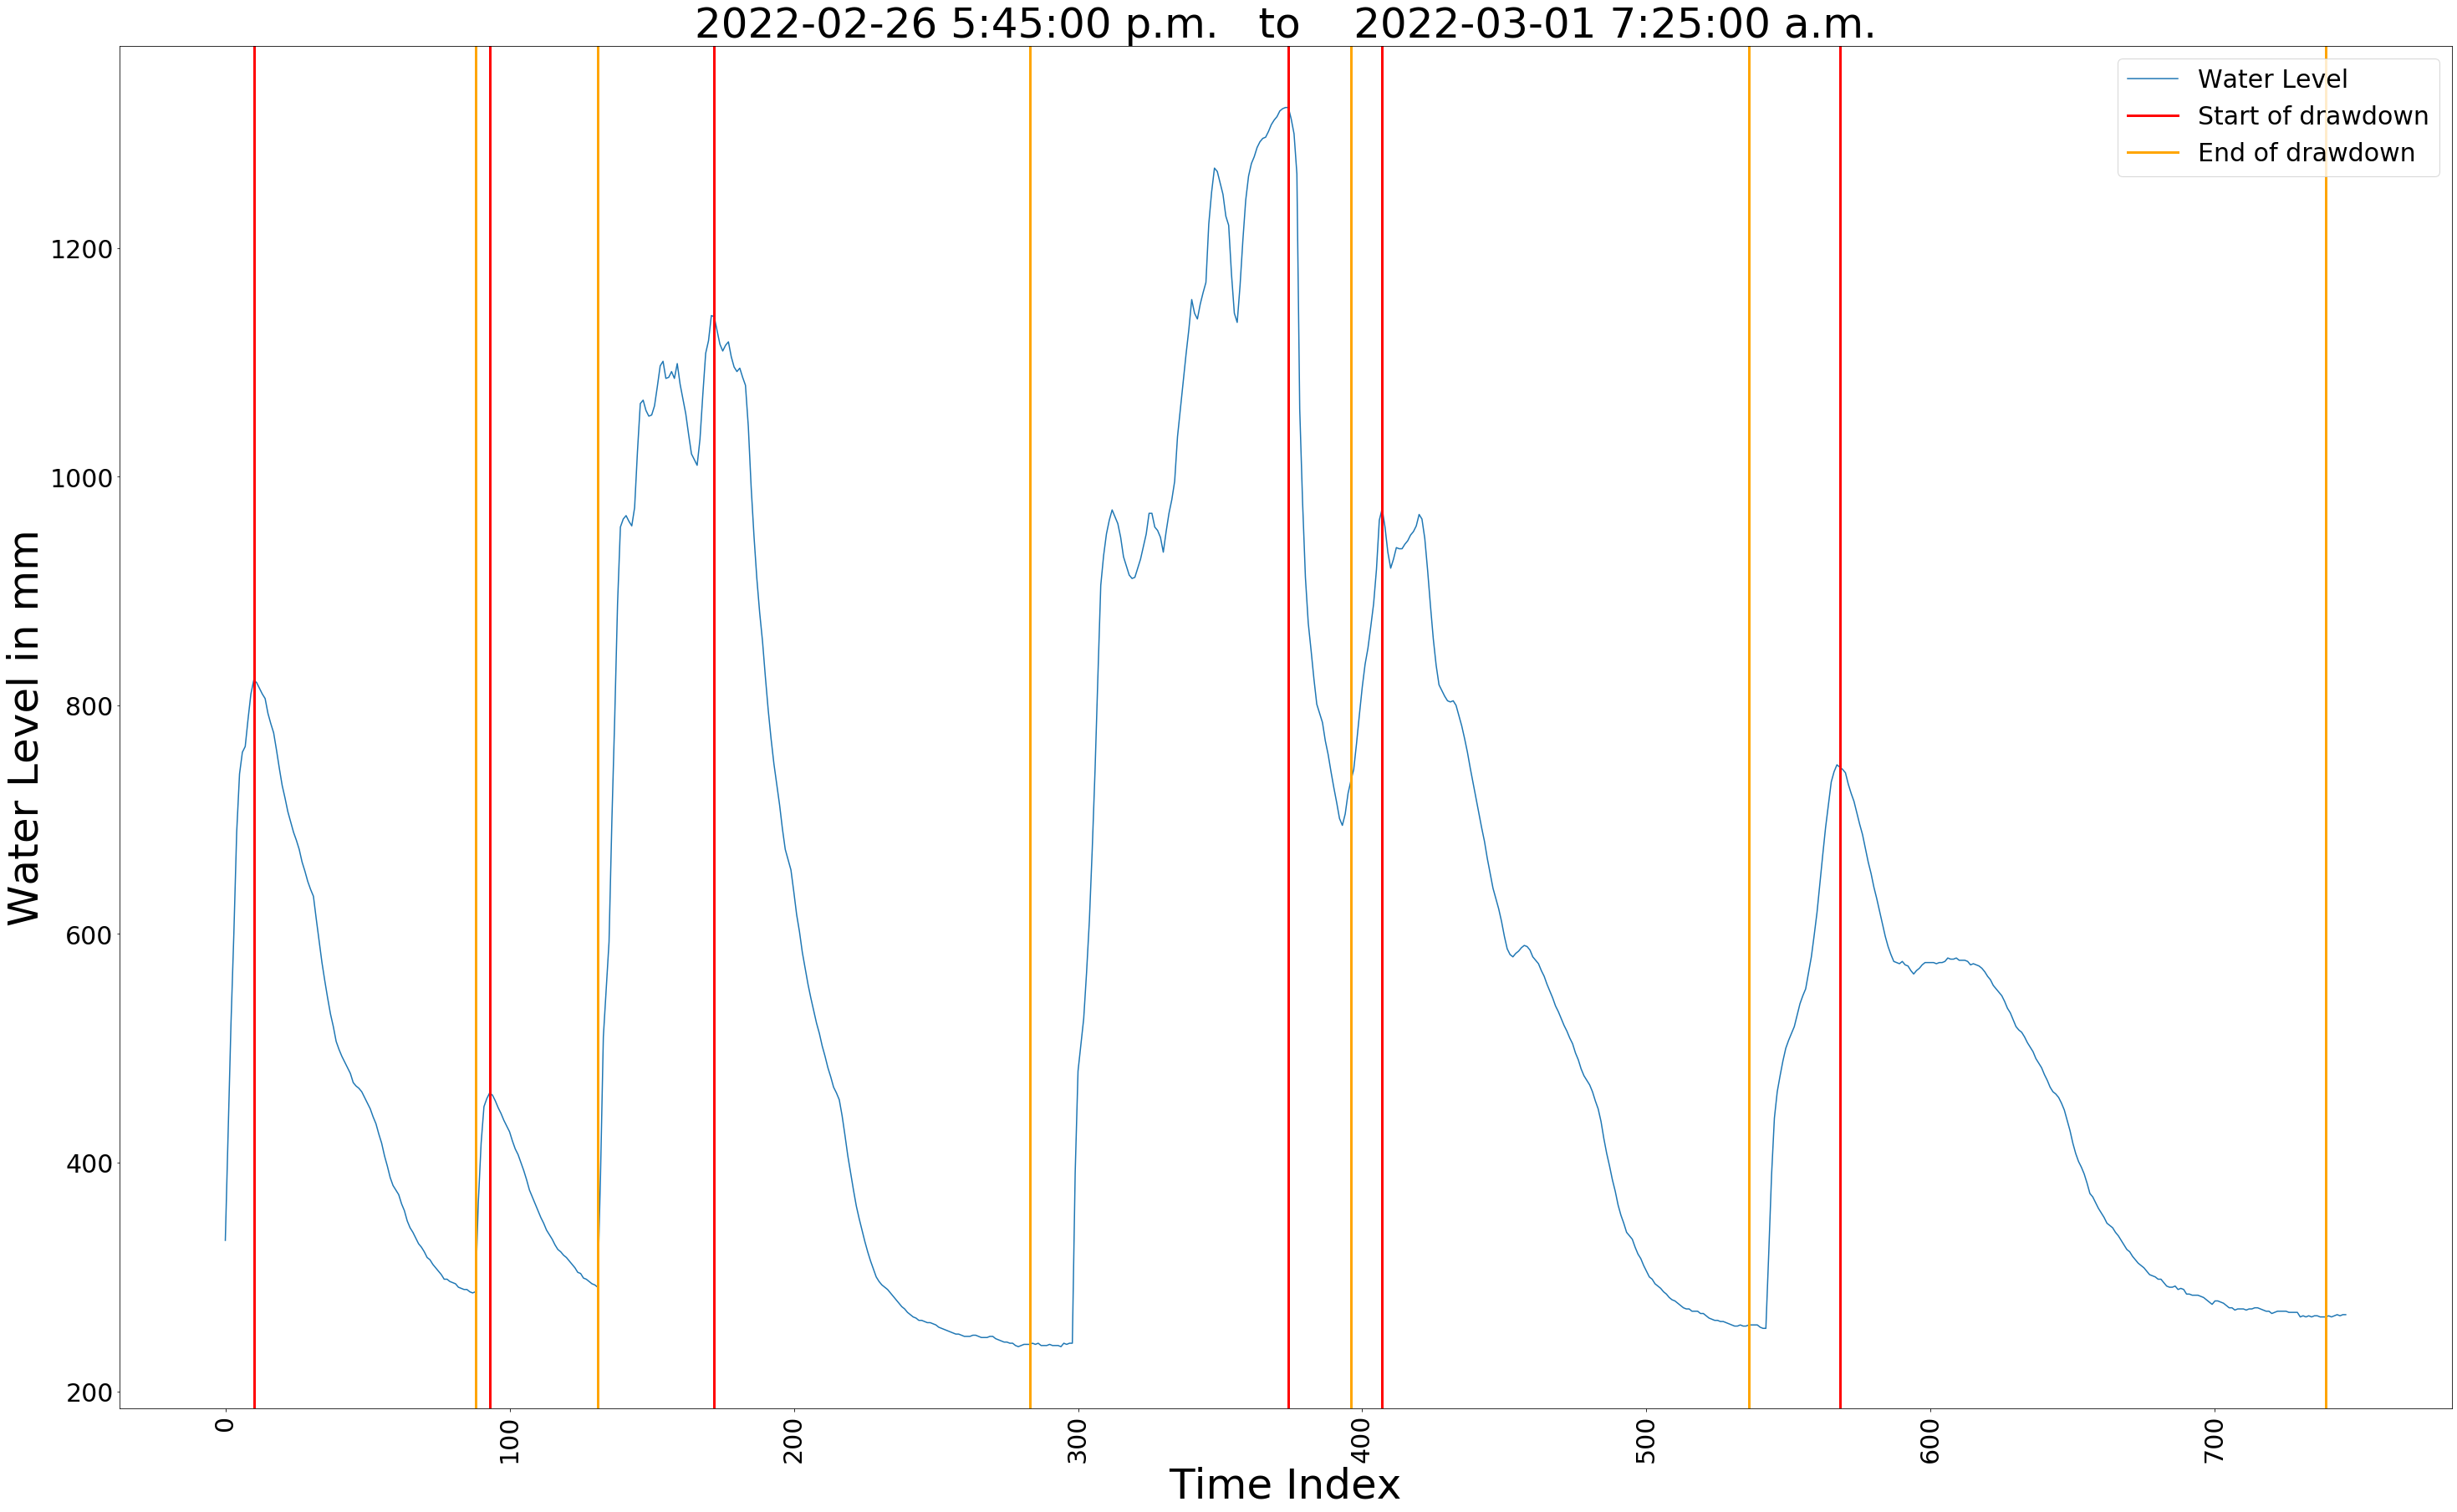

In [1324]:
plt.figure(figsize=(50, 30))
wle,=plt.plot(wl,label="Water Level")
for i in start:
    st=plt.axvline(x=i, linewidth=3,color='r',label="Start of drawdown")
for i in end:
    en=plt.axvline(x=i,linewidth=3, color='orange',label="End of drawdown")

plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,st,en],fontsize=30)
plt.title(start_timeA[index]+"   to    "+end_timeA[index],fontsize=50)
plt.show()

In [883]:
# This part is for site B

In [876]:
sBDF[" Water Level [m]"].where(sBDF[" Water Level [m]"]>0, 0,inplace=True)

In [1251]:
std_movB=moving_std(sBDF,6)
rng3pB=np.max(std_movB)*(3/100)
rng8pB=np.max(std_movB)*(8/100)

In [1250]:
start_timeB,end_timeB,start_indexB,end_indexB,rf_durationB,water_levelB=IdentifyEvents_3(sBDF,6,6)
rf_eventB=pd.DataFrame({"Rainfall_start_time":start_timeB,"Rainfall_end_time":end_timeB,"Rainfall_start_index":start_indexB,"Rainfall_end_index":end_indexB,"Rainfall_duration":rf_durationB})
rf_eventB

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-26 7:45:00 p.m.,2022-02-28 2:40:00 p.m.,3201,3716,515
1,2022-03-02 4:25:00 a.m.,2022-03-02 12:40:00 p.m.,4169,4268,99
2,2022-03-06 6:20:00 p.m.,2022-03-07 12:40:00 a.m.,5488,5564,76
3,2022-03-12 4:40:00 a.m.,2022-03-12 2:40:00 p.m.,7052,7172,120
4,2022-03-13 7:50:00 a.m.,2022-03-13 3:05:00 p.m.,7366,7453,87
5,2022-03-13 10:55:00 p.m.,2022-03-15 2:50:00 p.m.,7547,8026,479
6,2022-03-17 9:05:00 a.m.,2022-03-18 12:50:00 a.m.,8533,8722,189
7,2022-03-19 4:30:00 a.m.,2022-03-19 11:55:00 a.m.,9054,9143,89
8,2022-03-20 6:40:00 p.m.,2022-03-21 5:50:00 p.m.,9512,9790,278
9,2022-03-22 1:00:00 a.m.,2022-03-22 5:05:00 p.m.,9876,10069,193


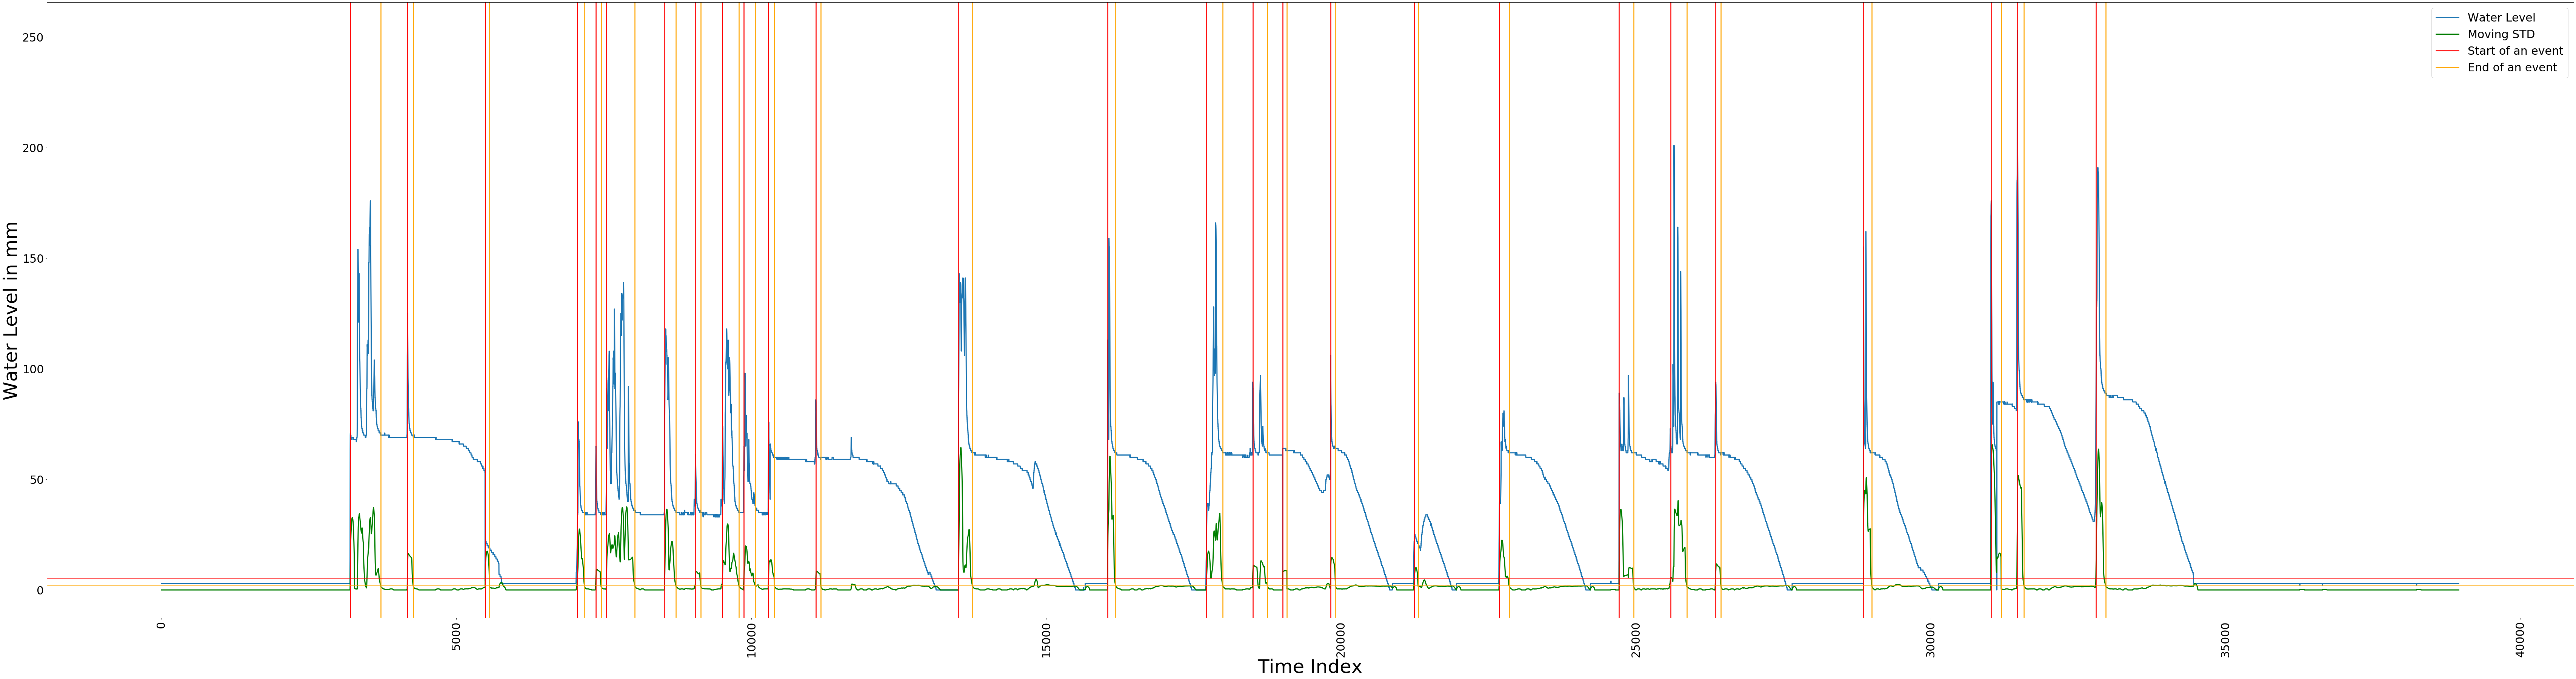

In [1252]:
plt.figure(figsize=(120, 30))
wle,=plt.plot(water_levelB,label='Water Level',linewidth=3)
mstd,=plt.plot(std_movB,label="Moving STD",linewidth=3,color="green")
for i in start_indexB:
    st=plt.axvline(x=i, linewidth=2.5,color='r',label="Start of an event")
for i in end_indexB:
    en=plt.axvline(x=i,linewidth=2.5, color='orange',label="End of an event")
plt.axhline(y=rng3pB, color='orange', linestyle='-')
plt.axhline(y=rng8pB, color='red', linestyle='-')
plt.xlabel('Time Index',fontsize=50)
plt.ylabel('Water Level in mm',fontsize=50)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',handles=[wle,mstd,st,en],fontsize=30)
plt.show()

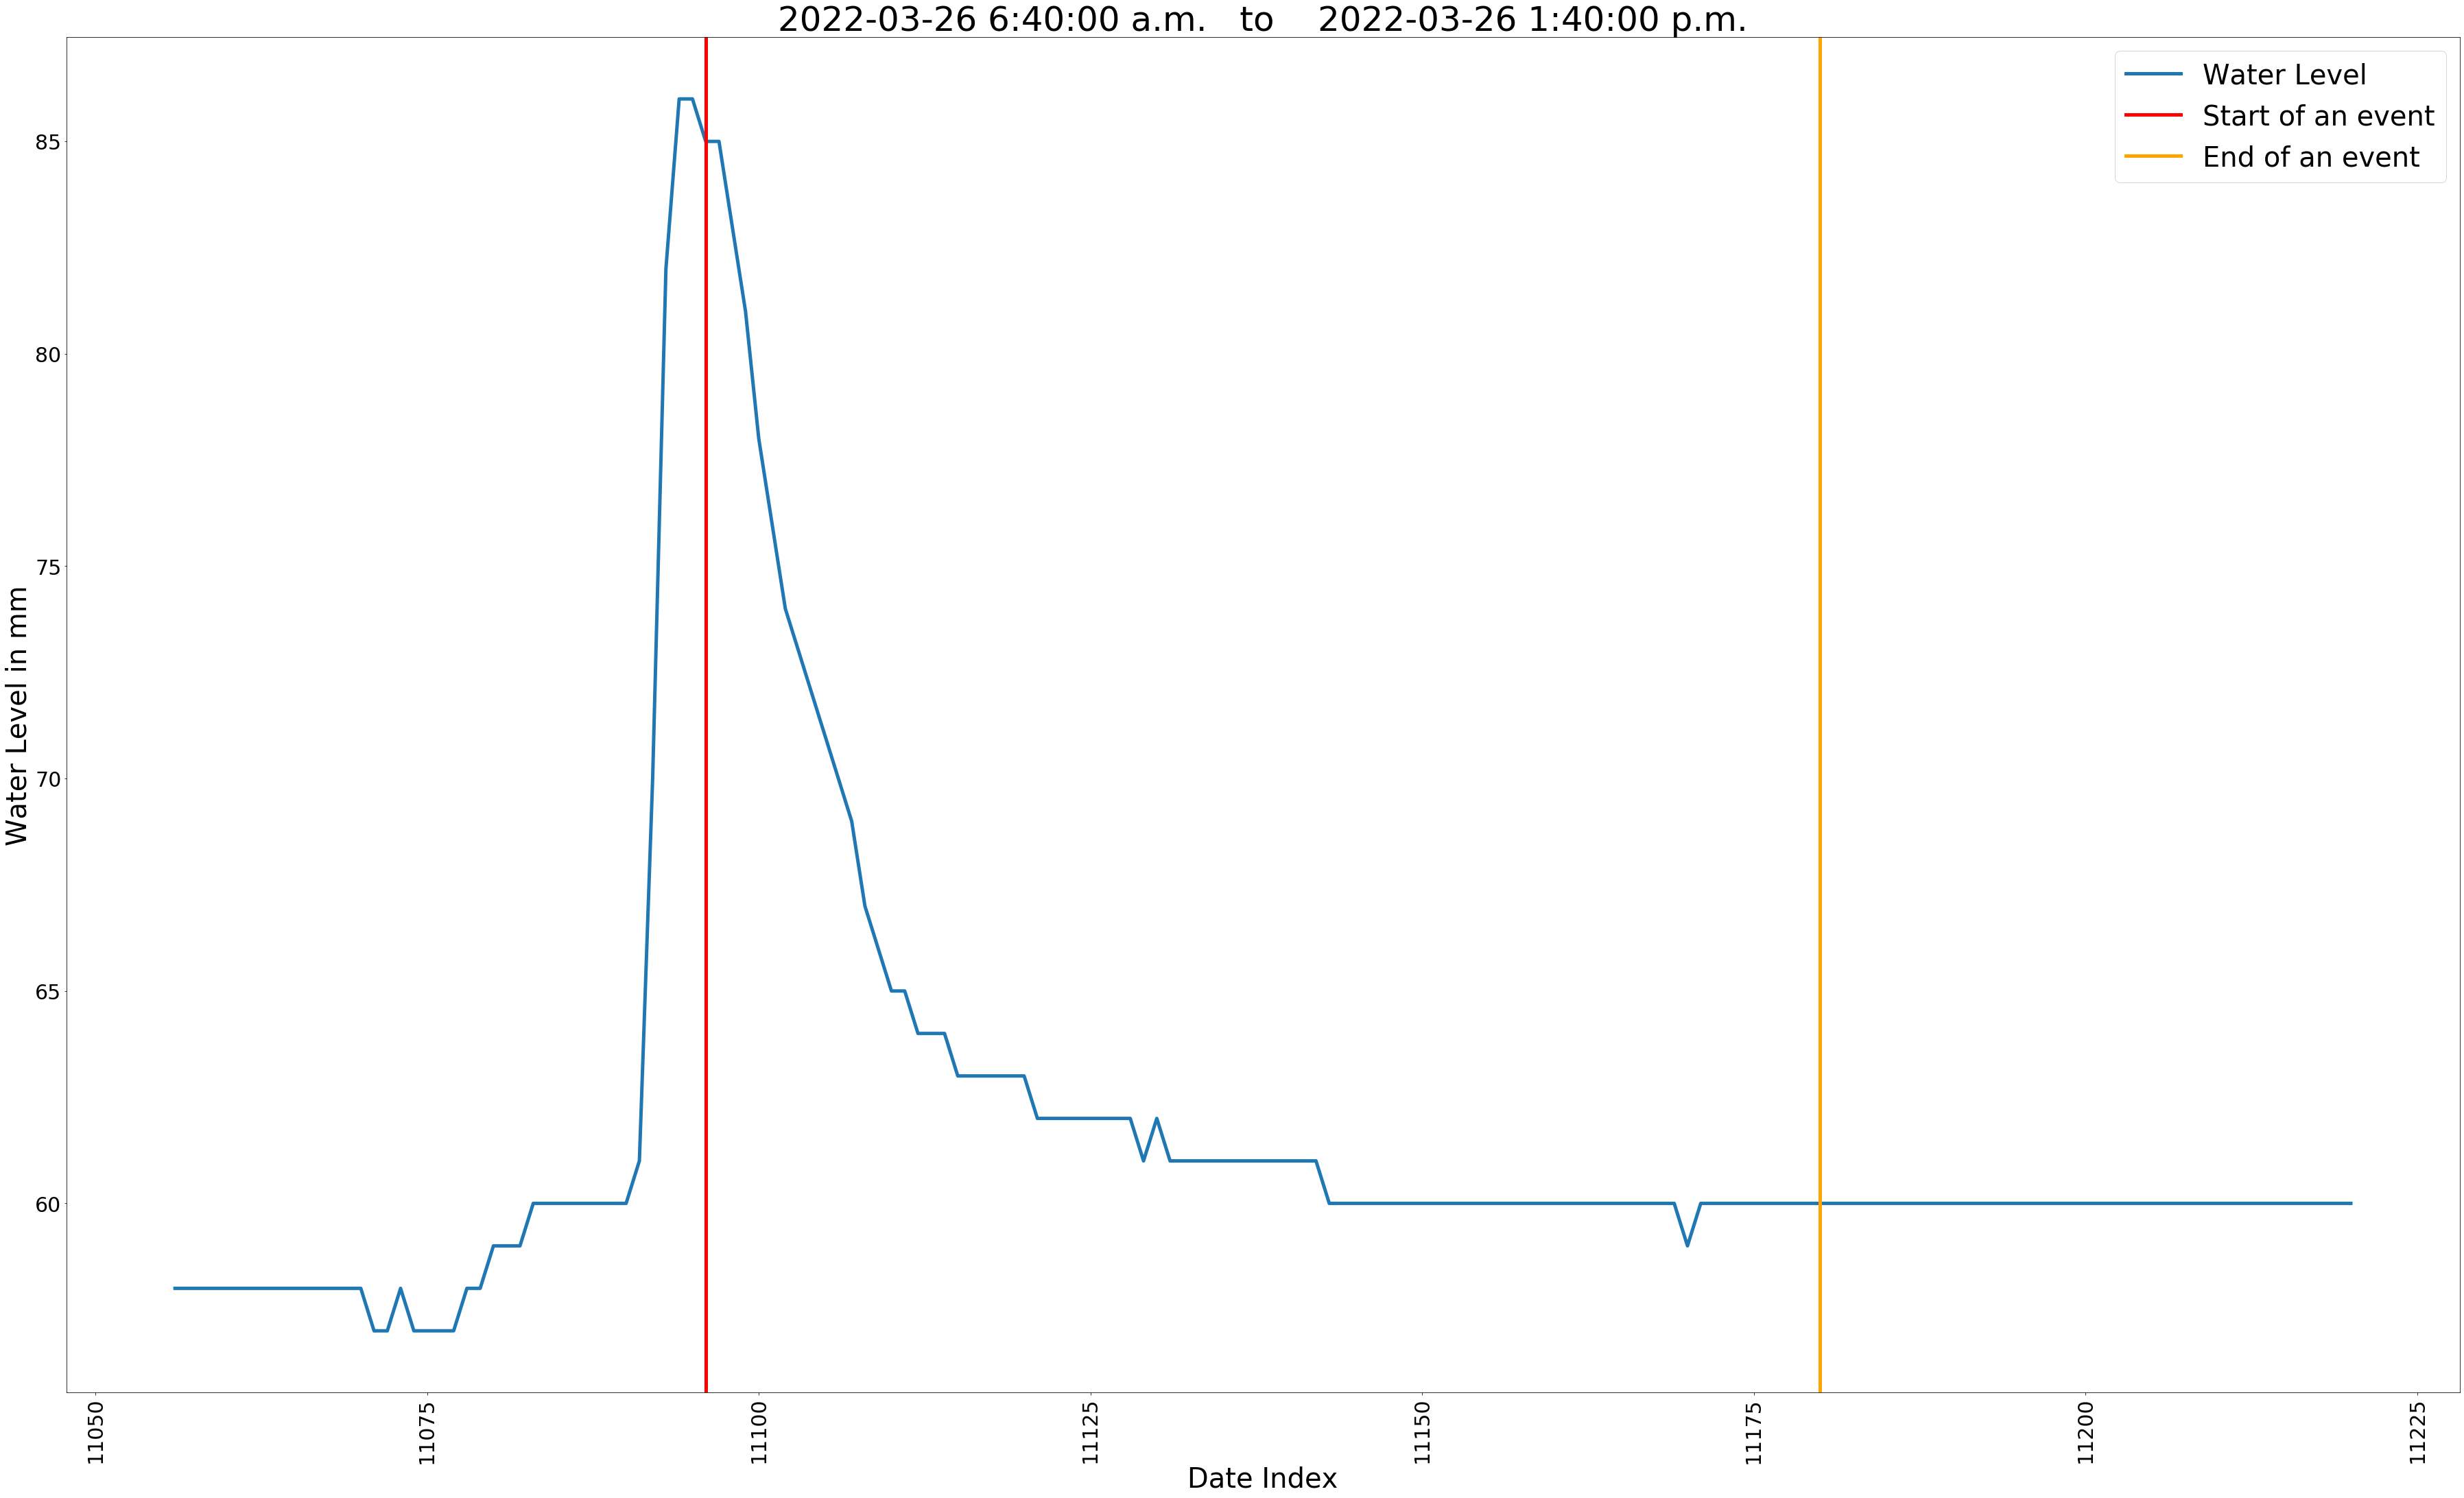

In [881]:
# Let's see a particular !Rainfall event
buffer=40
index=11
#X=Timestamp[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer+1]
X=range(start_indexB[index]-buffer,end_indexB[index]+buffer+1)
Y=water_levelB[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index],linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index],linewidth=5, color='orange',label="End of an event")
plt.title('Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.tight_layout()
plt.title(start_timeB[index]+"   to    "+end_timeB[index],fontsize=50)
plt.show()

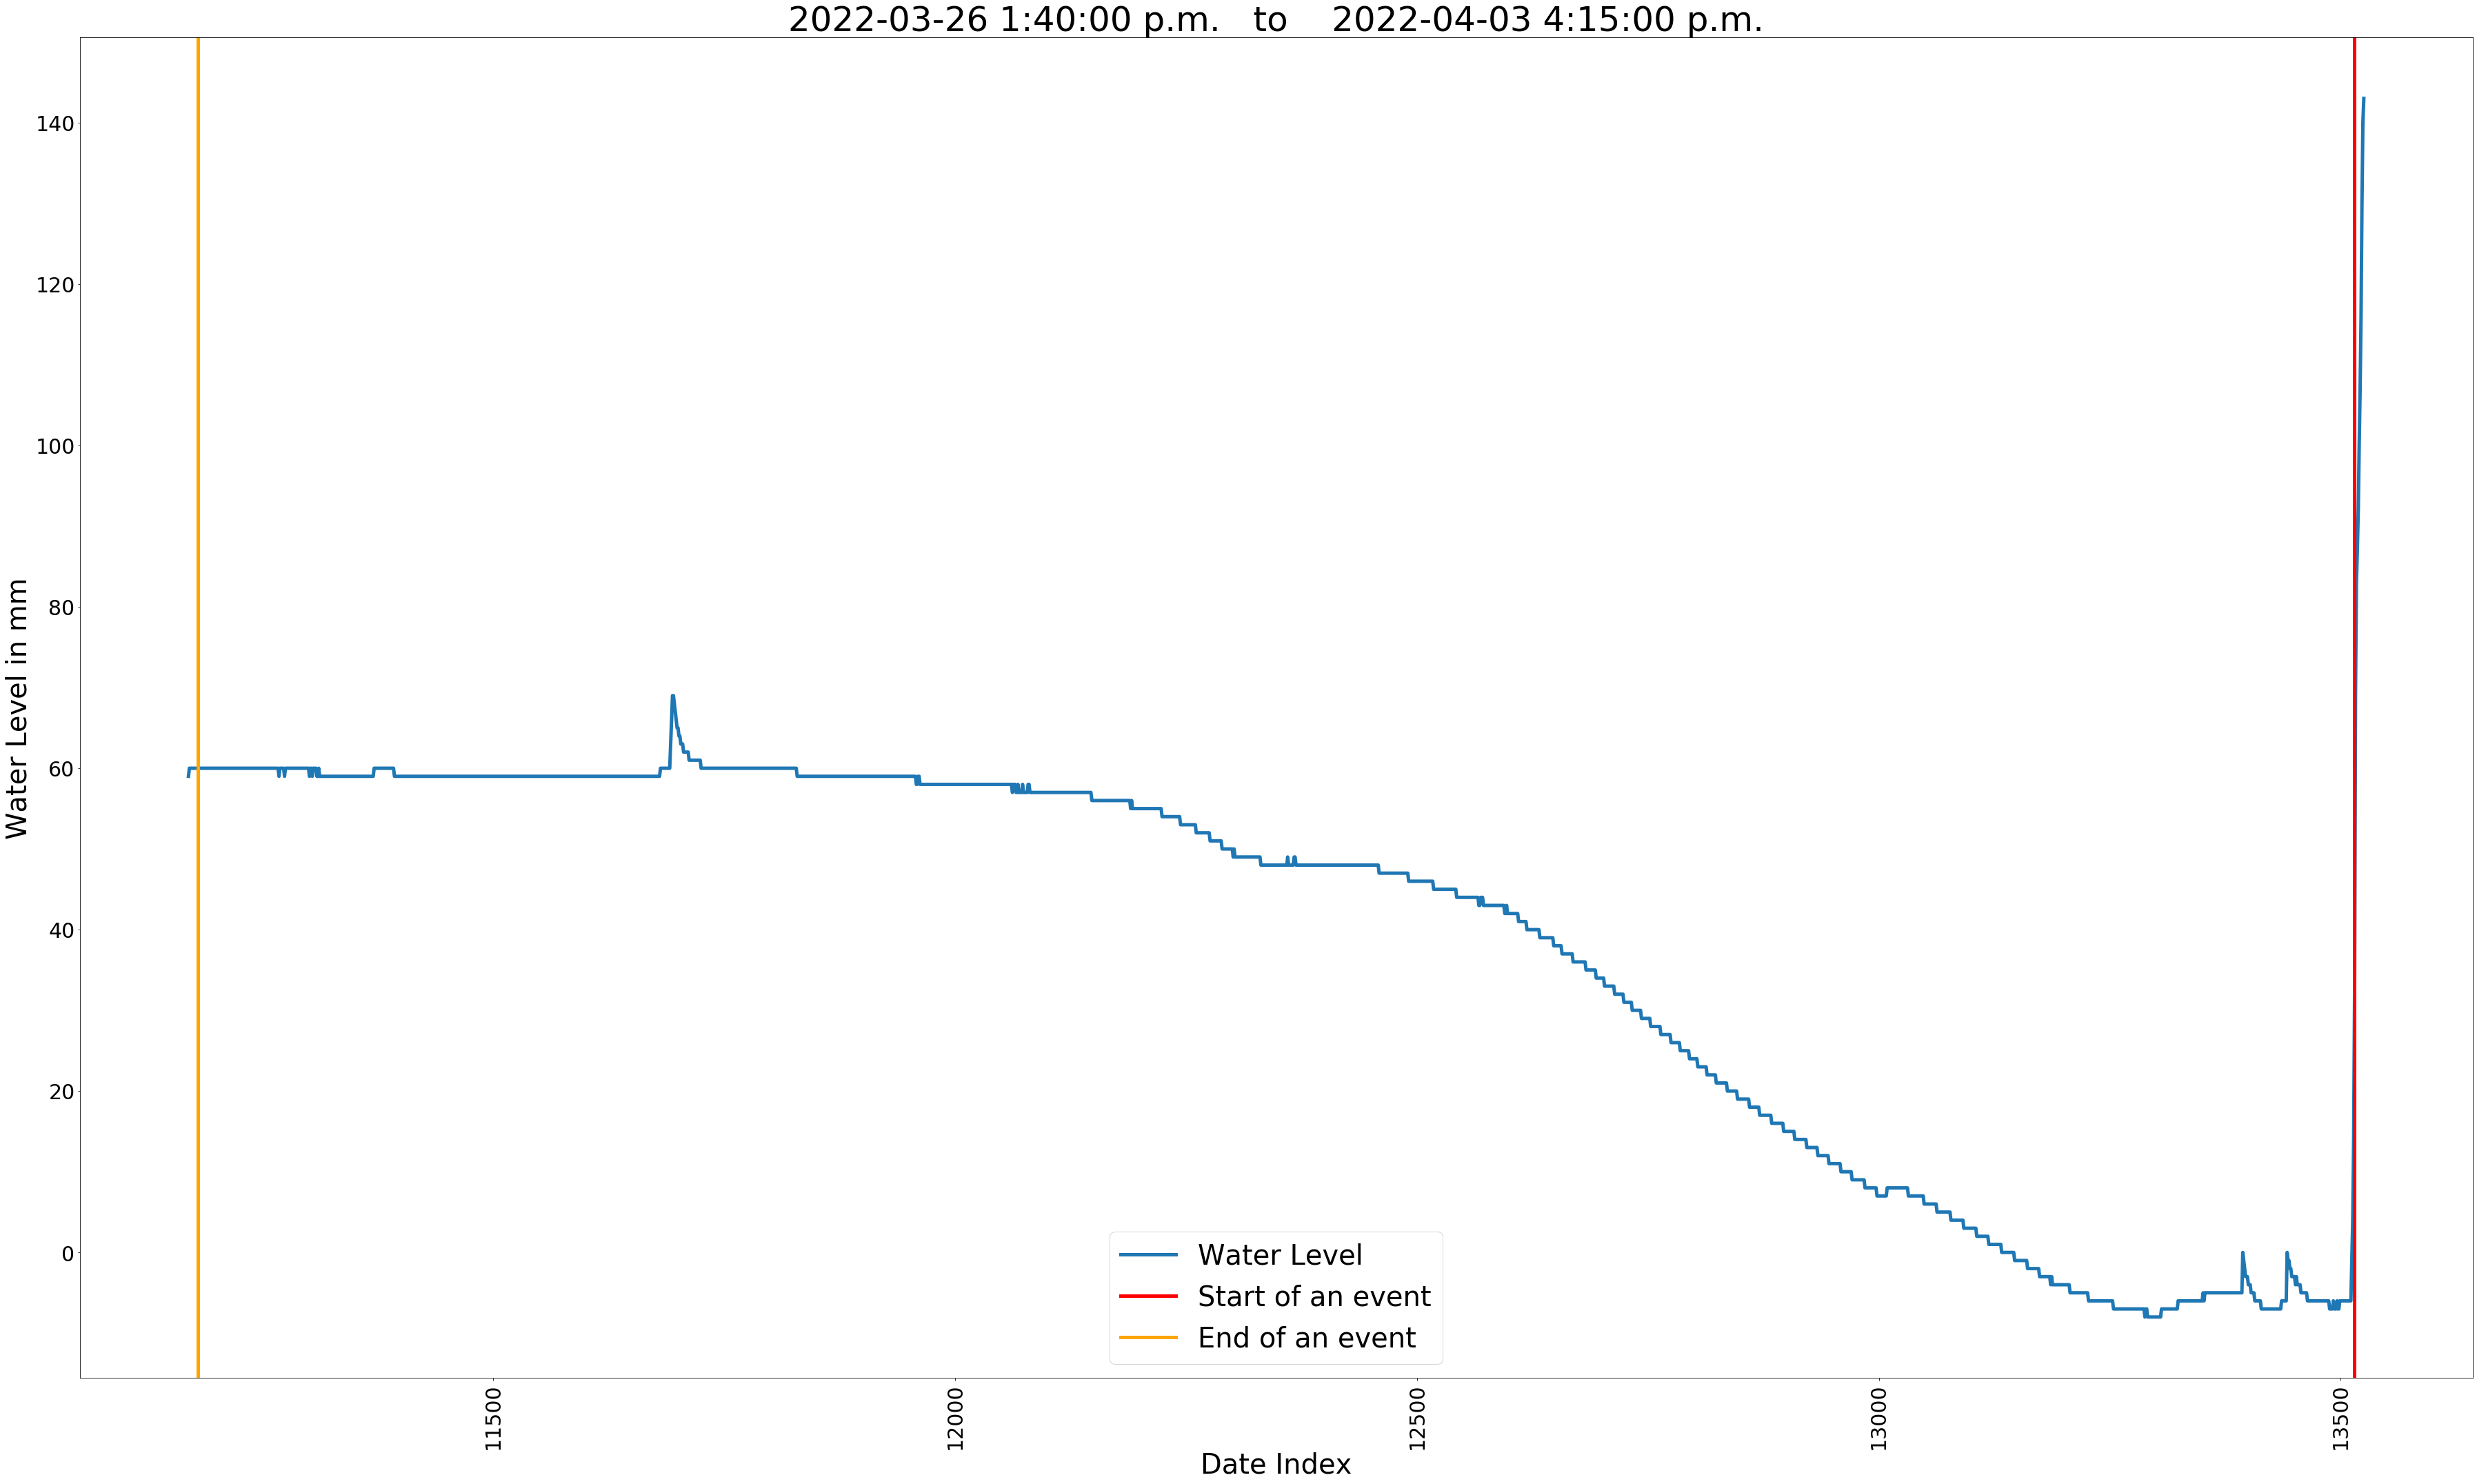

In [659]:
# Let's look at a particular No !Rainfall event
buffer=10
index=8
X=range(end_indexB[index-1]-buffer,start_indexB[index]+buffer+1)
Y=water_levelB[rf_eventB["Rainfall_end_index"][index-1]-buffer:rf_eventB["Rainfall_start_index"][index]+buffer+1]
plt.figure(figsize=(50, 30))
plt.plot(X,Y,linewidth=5,label="Water Level")
plt.axvline(x=start_indexB[index], linewidth=5,color='r',label="Start of an event")
plt.axvline(x=end_indexB[index-1],linewidth=5, color='orange',label="End of an event")
plt.title('No Rainfall Event')
plt.xlabel('Date Index',fontsize=40)
plt.ylabel('Water Level in mm',fontsize=40)
plt.tick_params(axis='x',labelsize=30,rotation=90)
plt.tick_params(axis='y',labelsize=30)
plt.legend(loc = 'best',fontsize=40)
plt.title(end_timeB[index-1]+"   to    "+start_timeB[index],fontsize=50)
plt.tight_layout()
plt.show()